In [ ]:

import h5py 

from google.colab import drive

from PIL import Image
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import random as r
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from matplotlib import pyplot as plt
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dense, Dropout, Activation, Concatenate, Flatten
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from zipfile import ZipFile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


drive.mount('/content/drive/')

In [ ]:
# Параметры аугментации
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Пути к папкам
train_nuclMask_folder = '/content/drive/My Drive/MECOS_ALL/MaskNucl/TRAIN' 
test_nuclMask_folder = '/content/drive/My Drive/MECOS_ALL/MaskNucl/TEST'

train_cellMask_folder = '/content/drive/My Drive/MECOS_ALL/MaskCell/TRAIN' 
test_cellMask_folder = '/content/drive/My Drive/MECOS_ALL/MaskCell/TEST'




# Ширина и высота изображения
size = 200

# Размер батча
BS = 16 

# Подсчёт весовых коэффициентов для классов в силу их различной представленности
len_train_Blast = len(os.listdir( os.path.join( train_noMask_folder , 'b' ) ))
len_train_Lymph = len(os.listdir( os.path.join( train_noMask_folder , 'l' ) ))
len_train_Monoc = len(os.listdir( os.path.join( train_noMask_folder , 'm' ) ))

print('len b', len_train_Blast)
print('len l', len_train_Lymph)
print('len m', len_train_Monoc)

len_train = len_train_Blast + len_train_Lymph + len_train_Monoc

w_b = len_train/(3*len_train_Blast)
w_l = len_train/(3*len_train_Lymph)
w_m = len_train/(3*len_train_Monoc)

# Генераторы подаются на вход обучающей функции и формируют батчи "на лету"

# Генератор изображений с масками ядер
nuclMask_train_generator = train_datagen.flow_from_directory(
                    train_nuclMask_folder, 
                    target_size=(size, size),
                    batch_size=BS,
                    class_mode='sparse')

nuclMask_test_generator = test_datagen.flow_from_directory(
                    test_nuclMask_folder,
                    target_size=(size, size),
                    batch_size=BS,
                    class_mode='sparse')


# Генератор изображений с масками клеток
cellMask_train_generator = train_datagen.flow_from_directory(
                    train_cellMask_folder, 
                    target_size=(size, size),
                    batch_size=BS,
                    class_mode='sparse')

cellMask_test_generator = test_datagen.flow_from_directory(
                    test_cellMask_folder,
                    target_size=(size, size),
                    batch_size=BS,
                    class_mode='sparse')


**Создание архитектуры модели для изображений с масками ядер. VGG-подобная архитектура, т.е. линейная последовательность сверточных слоёв, с возрастающим кол-вом каналов, и слоёв пуллинга. В конце идут полносвязные слои**

In [ ]:
l2_lambda = 0.001

nuclMask_model = models.Sequential()
  
  # -- Блок 1 --
  
nuclMask_model.add(Conv2D(32, (3, 3), 
                          input_shape=(size, size, 3),
                   
                          activation='relu', 
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))
  
  #inp=layers.Input(shape=(size, size, 3))
nuclMask_model.add(Conv2D(32, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))

nuclMask_model.add(MaxPooling2D((2, 2)))

  # -- Блок 2 --

nuclMask_model.add(Conv2D(64, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))
  
nuclMask_model.add(Conv2D(64, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))

nuclMask_model.add(MaxPooling2D((2, 2)))

  # -- Блок 3 --

nuclMask_model.add(Conv2D(128, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))
  
nuclMask_model.add(Conv2D(128, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))

nuclMask_model.add(MaxPooling2D((2, 2)))

  # -- Блок 4 --

nuclMask_model.add(Conv2D(256, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))
  
nuclMask_model.add(Conv2D(256, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))

nuclMask_model.add(MaxPooling2D((2, 2)))

  # -- Полносвязный слой --

nuclMask_model.add(Flatten())

nuclMask_model.add(Dropout(0.25))

nuclMask_model.add(Dense(256, activation='relu', 
                         kernel_initializer=initializers.he_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda)))

nuclMask_model.add(Dropout(0.25))

  # -- Выходной слой --

nuclMask_model.add(Dense(3, activation='softmax',
                         kernel_initializer=initializers.glorot_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda)))


**Создание такой же архитектуры, но для изображений с масками целых клеток**

In [ ]:
l2_lambda = 0.001

cellMask_model = models.Sequential()
  
  # -- Блок 1 --
  
cellMask_model.add(Conv2D(32, (3, 3), 
                          input_shape=(size, size, 3),
                   
                          activation='relu', 
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))
  
  #inp=layers.Input(shape=(size, size, 3))
cellMask_model.add(Conv2D(32, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))

cellMask_model.add(MaxPooling2D((2, 2)))

  # -- Блок 2 --

cellMask_model.add(Conv2D(64, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))
  
cellMask_model.add(Conv2D(64, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))

cellMask_model.add(MaxPooling2D((2, 2)))

  # -- Блок 3 --

cellMask_model.add(Conv2D(128, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))
  
cellMask_model.add(Conv2D(128, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))

cellMask_model.add(MaxPooling2D((2, 2)))

  # -- Блок 4 --

cellMask_model.add(Conv2D(256, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))
  
cellMask_model.add(Conv2D(256, (3, 3), activation='relu',
                          kernel_initializer=initializers.he_uniform(),
                          kernel_regularizer=regularizers.l2(l2_lambda)))

cellMask_model.add(MaxPooling2D((2, 2)))

  # -- Полносвязный слой --

cellMask_model.add(Flatten())

cellMask_model.add(Dropout(0.25))

cellMask_model.add(Dense(256, activation='relu', 
                         kernel_initializer=initializers.he_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda)))

cellMask_model.add(Dropout(0.25))

  # -- Выходной слой --

cellMask_model.add(Dense(3, activation='softmax',
                         kernel_initializer=initializers.glorot_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda)))

**Создание сети, состоящей из Inception-блоков: несколько различных слоёв получают одно и то же изображениие, затем результаты их преобразований конкатенируются. На картинке ниже представлен один из вариантов построения такого блока. В нашей архитектуре использовался упрощённый, менее глубокий блок**
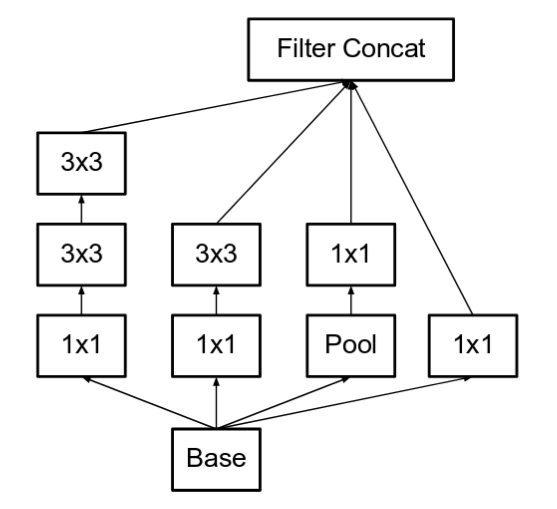

In [ ]:
lyamb=0.001
inp = Input(shape=(size,size,3))

##
conv_1=Conv2D(32 , (3,3) , activation = 'relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb) )(inp)
pool_1=MaxPooling2D((2,2))(conv_1)
##

conv_2=Conv2D(64 , (3,3) , activation = 'relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb) )(pool_1)
pool_2=MaxPooling2D((2,2))(conv_2)
##
inc_1_a=Conv2D(128 , (1,1) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(pool_2)

inc_1_b=Conv2D(128 , (1,1) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(pool_2)

inc_1_b=Conv2D(128 , (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_b)



inc_1_c=Conv2D(128, (3,3), activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(pool_2) 

inc_1_c=MaxPooling2D( (2,2),strides=2 )(inc_1_c) 


inc_1_d=Conv2D(128 , (1,1) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(pool_2)

inc_1_d=Conv2D(128, (3,3) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_d)

inc_1_d=Conv2D(128, (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_d)

inc_1_out=Concatenate()([inc_1_a,inc_1_b,inc_1_c,inc_1_d])
print(inc_1_out.shape)
##
inc_2_a=Conv2D(128 , (1,1) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_out)

inc_2_b=Conv2D(128 , (1,1) , activation='relu',
             kernel_initializer=initializers.he_uniform(),  padding='same',          
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_out)

inc_2_b=Conv2D(128 , (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_b)

inc_2_c=Conv2D(128, (3,3), activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_out) 

inc_2_c=MaxPooling2D( (2,2) , strides=2)(inc_2_c) 

inc_2_d=Conv2D(128 , (1,1) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_out)

inc_2_d=Conv2D(128, (3,3) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_d)

inc_2_d=Conv2D(128, (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_d)

inc_2_out=Concatenate()([inc_2_a,inc_2_b,inc_2_c,inc_2_d])
##
inc_3_a=Conv2D(128 , (1,1) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_out)

inc_3_b=Conv2D(128 , (1,1) , activation='relu',
             kernel_initializer=initializers.he_uniform(), padding='same',           
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_out)

inc_3_b=Conv2D(128 , (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_3_b)

inc_3_c=Conv2D(128, (3,3), activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),          
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_out) 

inc_3_c=MaxPooling2D( (2,2) , strides=2)(inc_3_c) 

inc_3_d=Conv2D(128 , (1,1) , activation='relu',
             kernel_initializer=initializers.he_uniform(),  padding='same',          
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_out)

inc_3_d=Conv2D(128, (3,3) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_3_d)

inc_3_d=Conv2D(128, (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_3_d)

inc_3_out=Concatenate()([inc_3_a,inc_3_b,inc_3_c,inc_3_d])
##


flat=layers.Flatten()(inc_3_out)

dense_1=Dense(512, activation='relu', 
                         kernel_initializer=initializers.he_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda))(flat)

dense_2=Dense(128, activation='relu', 
                         kernel_initializer=initializers.he_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda))(dense_1)

out=Dense(3, activation='softmax',
                         kernel_initializer=initializers.glorot_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda))(dense_2)
  


  

modelInception = Model(inputs=inp , outputs = out)


**Конфигурация обучения для vgg-подобных сетей**

In [ ]:
# Колбек используется для сохранения модели с лучшей точностью в конкретную эпоху
callbacks = [
    ModelCheckpoint('cellMask_model.h5', verbose=1, monitor = 'val_accuracy', save_best_only=True)
            ]
# loss - функция потерь, оптимизатор- 'adam', метрика - точность

cellMask_model.compile(loss='sparse_categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'] )

# весовые коэффициенты для устранения неравномерности выборки

w_b = 2.6
w_l = 0.5
w_m = 2.1

results = cellMask_model.fit(cellMask_train_generator,
                               epochs = 65,
                               callbacks=callbacks,
                               class_weight={ 0:w_b, 1:w_l, 2:w_m },
                               steps_per_epoch= len_train ,
                               validation_steps= len_train ,
                               validation_data=cellMask_test_generator)


nuclMask_model.compile(loss='sparse_categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'] )

# весовые коэффициенты для устранения неравномерности выборки

w_b = 2.6
w_l = 0.5
w_m = 2.1

results = cellMask_model.fit(cellMask_train_generator,
                               epochs = 65,
                               callbacks=callbacks,
                               class_weight={ 0:w_b, 1:w_l, 2:w_m },
                               steps_per_epoch= len_train ,
                               validation_steps= len_train ,
                               validation_data=cellMask_test_generator)

**Конфигурация обучения для сети с Inception-блоками**

In [ ]:
CB=[
   callbacks.ModelCheckpoint(filepath='Inception_model.h5',monitor='val_accuracy',save_best_only=True)]

# Здесь оптимизатор использовал RMSprop

rms=optimizers.RMSprop(lr=0.0001, rho=0.99, epsilon=None, decay=0.0)
 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adaG,metrics=['acc'])

w_b = 2.6
w_l = 0.5
w_m = 2.1

model.fit_generator(
   cellMask_train_generator,
  steps_per_epoch=len_traib,
   epochs=60,
    
    class_weight={ 0:w_b, 1:w_l, 2:w_m },
    callbacks=CB,
      validation_data=cellMask_test_generator
   )



**Создание ансамбля моделей и функция для предсказания**

In [ ]:
def predictAsEnsemble( imgCell, imgNucl, model1, model2, model3 ):
  imgCell = imgCell.reshape((1,)+imgCell.shape)
  imgNucl = imgNucl.reshape((1,)+imgNucl.shape)

  pred1 = model1.predict(imgNucl)
  pred2 = model2.predict(imgCell)
  pred3 = model3.predict(imgCell)

  ensembRes = np.add( np.add(pred1,pred2) , pred3 ) / 3

# # # # # # # # # # # 

origImg = cv.imread('origImg.jpg')
nuclMask = cv.imread('nuclMask.jpg',0)
cellMask = cv.imread('cellMask.jpg',0)

imgNuck = cv.bitwise_add(origImg, nuclMask)
imgCell = cv.bitwise_add(origImg, cellMask)


predctAsEnsemble( imgCell, imgNucl , nuclMask_model, cellMask_model, modelInception )


